<a href="https://colab.research.google.com/github/cemsanga/MAT555E_Assignments/blob/main/HW4_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
from collections import Counter
from os import path
from sklearn.model_selection import train_test_split
from scipy.stats import chisquare
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost as xgb
from keras.backend import clear_session

import tensorflow as tf
import keras as ks

import warnings
#warnings.filterwarnings('ignore')

# HW 4

# Q1

For this question we are going to use [1994 Census Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult).

Construct 

- Logistic regression
- SVM
- KNN
- Decision tree
- Gradient Boost (XGBoost)
- Neural network

models for the data. Cross-validate your models and measure the accuracies. Compare them putting the accuracies in a table.

## Data Handling

In [3]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',header=None)

I will take the column names from the file `adult.names` which was presented at the data source.

In [4]:
if path.exists("adult.names") == True:
    f = open('adult.names', "r")
    lines = f.readlines()
    descriptions = lines[-14:]
    col_names = []
    for x in descriptions:
        label = x.split(":")[0]
        col_names.append(label)
else:
    col_names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country']

We also need to add the target variable `income` to the columns

In [5]:
col_names.append("income")
col_names

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'income']

In [6]:
col_index = [i for i in range(len(col_names))]
col_dict = dict(zip(col_index,col_names))
origin_df = pd.DataFrame(data)
origin_df.rename(col_dict, axis=1, inplace = True)
df = origin_df
origin_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [7]:
categorical = ["workclass", "education", "marital-status" , "occupation" , "relationship", "race", "sex", "native-country"]

Next, I will use a code snippet that I took from my classmate *Ahmet Süheyl Kiriş*. As we discussed in class, dealing with categorical data is problematic since every labeling we can do instead of the categories can be biased depending on the label type. So we give every option of a category an individual column. These new columns will only have binary values of $0$ or $1$, depending whether that row has that attribute. With my sincere gratitude to the owner, I name the snippet, _SuheylBinarizer_. (Later, we have noticed that LabelBinarizer does the same thing but it is still good for his citation count this way.)

The list `categorical values` only contains the columns of the dataset that has categorical parameters. At the end of the next code cell, `df` will be a DataFrame containing only the new binary columns.

In [8]:
# Süheyl Binarizer

trivial = np.zeros((32561,1)).astype(int)
df = pd.DataFrame(trivial, columns = ["Deneme"])

for a in range(len(categorical)):
    arr_unique = np.unique(data[categorical[a]])
    arr = data[categorical[a]]
    clmns = []
    
    for u in arr_unique:
        string = str(categorical[a]) + str(u)
        clmns.append(string)

    matrix = np.zeros((32561,len(arr_unique)))
    for i in range(len(arr_unique)):
        for j in range(32561):
            if arr[j] == arr_unique[i]:
                matrix[j][i] = 1;
    matrix = matrix.astype(int)
    df2 = pd.DataFrame(matrix, columns = clmns)
    df = df.join(df2)
df = df.drop(["Deneme"], axis=1)

Now I drop the original categorical columns from the initial `data` DataFrame and add the newly formed binary columns.

In [9]:
reduced_origin_df = origin_df.drop(categorical,axis = 1)
reduced_origin_df


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
0,39,77516,13,2174,0,40,<=50K
1,50,83311,13,0,0,13,<=50K
2,38,215646,9,0,0,40,<=50K
3,53,234721,7,0,0,40,<=50K
4,28,338409,13,0,0,40,<=50K
...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,<=50K
32557,40,154374,9,0,0,40,>50K
32558,58,151910,9,0,0,40,<=50K
32559,22,201490,9,0,0,20,<=50K


We need to join two dataframes by means of columns. Since the row indices are same, we can do this by `concat` function.

In [10]:
final_data = pd.concat([df,reduced_origin_df],axis = 1)

Using the helper function to convert the income column to binary values.

In [11]:
def helper(x):
    if ('<=' in x):
        return 0
    else:
        return 1
    
y = [helper(x) for x in data.iloc[:,14]]
final_data['income'] = y
final_data

,workclass ?,workclass Federal-gov,workclass Local-gov,workclass Never-worked,workclass Private,workclass Self-emp-inc,workclass Self-emp-not-inc,workclass State-gov,workclass Without-pay,education 10th,...,native-country United-States,native-country Vietnam,native-country Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,39,77516,13,2174,0,40,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,50,83311,13,0,0,13,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,38,215646,9,0,0,40,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,53,234721,7,0,0,40,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,28,338409,13,0,0,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,0,1,0,0,0,0,0,...,1,0,0,27,257302,12,0,0,38,0
32557,0,0,0,0,1,0,0,0,0,0,...,1,0,0,40,154374,9,0,0,40,1
32558,0,0,0,0,1,0,0,0,0,0,...,1,0,0,58,151910,9,0,0,40,0
32559,0,0,0,0,1,0,0,0,0,0,...,1,0,0,22,201490,9,0,0,20,0


## Logistic Regression

Creating the Logistic regression model...

In [12]:
x = final_data.iloc[:,0:-1]
y = final_data.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30)

LogResModel = LogisticRegression(C=1.0,penalty="l2",multi_class="multinomial",max_iter=10000,tol=1e-2,solver="newton-cg")
LogResModel.fit(x_train,y_train)
LogResPred = LogResModel.predict(x_test)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [83]:
def LogResResults():
    print("Accuracy = ",accuracy_score(LogResPred,y_test))
    print("Confusion Matrix = \n",confusion_matrix(LogResPred,y_test))
LogResResults()
LogResScore = accuracy_score(LogResPred,y_test)

Accuracy =  0.8546422356433616
Confusion Matrix = 
 [[6958  948]
 [ 472 1391]]


## Support Vector Machine (SVM)

In [80]:
SVM_Model = SVC(C = 2, kernel="rbf",tol= 0.001,max_iter=20000)

SVM_Model.fit(x_train,y_train)
SVM_Pred = SVM_Model.predict(x_test)
def SVMResults():
    print("Accuracy = ",accuracy_score(SVM_Pred,y_test))
    print("Confusion Matrix = \n",confusion_matrix(SVM_Pred,y_test))
SVM_Score = accuracy_score(SVM_Pred,y_test)

In [81]:
SVMResults()

Accuracy =  0.7995700685842972
Confusion Matrix = 
 [[7416 1944]
 [  14  395]]


## K-Nearest Neighbor

In [70]:
KNN_scores = []
def KNN_Exp(N):
    global KNN_scores
    KNN_Model = KNeighborsClassifier(n_neighbors=N)
    KNN_Model.fit(x_train,y_train)
    KNN_Pred = KNN_Model.predict(x_test)
    KNN_scores.append(accuracy_score(KNN_Pred,y_test))
    print("Accuracy = ",accuracy_score(KNN_Pred,y_test))
    print("Confusion Matrix = \n",confusion_matrix(KNN_Pred,y_test))

In [71]:
for i in np.arange(2,12):
    print(i)
    KNN_Exp(i)

2
Accuracy =  0.7908690756474562
Confusion Matrix = 
 [[7097 1710]
 [ 333  629]]
3
Accuracy =  0.7613880642849831
Confusion Matrix = 
 [[6608 1509]
 [ 822  830]]
4
Accuracy =  0.7900501586651654
Confusion Matrix = 
 [[7119 1740]
 [ 311  599]]
5
Accuracy =  0.7777664039308015
Confusion Matrix = 
 [[6886 1627]
 [ 544  712]]
6
Accuracy =  0.7936329204626881
Confusion Matrix = 
 [[7178 1764]
 [ 252  575]]
7
Accuracy =  0.7865697614904289
Confusion Matrix = 
 [[7031 1686]
 [ 399  653]]
8
Accuracy =  0.7952707544272699
Confusion Matrix = 
 [[7226 1796]
 [ 204  543]]
9
Accuracy =  0.7912785341386017
Confusion Matrix = 
 [[7129 1738]
 [ 301  601]]
10
Accuracy =  0.7967038591462791
Confusion Matrix = 
 [[7260 1816]
 [ 170  523]]
11
Accuracy =  0.7954754836728427
Confusion Matrix = 
 [[7197 1765]
 [ 233  574]]


In [72]:
KNN_scores

[0.7908690756474562,
 0.7613880642849831,
 0.7900501586651654,
 0.7777664039308015,
 0.7936329204626881,
 0.7865697614904289,
 0.7952707544272699,
 0.7912785341386017,
 0.7967038591462791,
 0.7954754836728427]

Highest value is acquired by neighbors of 10. So, n is going to be 10.

## Decision Trees

In [74]:
DT_Model = DecisionTreeClassifier(max_depth=36, criterion="entropy")
DT_Model.fit(x,y)
DT_Score = DT_Model.score(x,y)
print(DT_Score)

0.990018734068364


[Text(0.5072115384615384, 0.9166666666666666, 'X[27] <= 0.5\nentropy = 0.796\nsamples = 32561\nvalue = [24720, 7841]'),
 Text(0.25961538461538464, 0.75, 'X[105] <= 7073.5\nentropy = 0.348\nsamples = 17585\nvalue = [16436, 1149]'),
 Text(0.15384615384615385, 0.5833333333333334, 'X[104] <= 12.5\nentropy = 0.283\nsamples = 17274\nvalue = [16425, 849]'),
 Text(0.07692307692307693, 0.4166666666666667, 'X[102] <= 28.5\nentropy = 0.167\nsamples = 13864\nvalue = [13522, 342]'),
 Text(0.038461538461538464, 0.25, 'X[102] <= 21.5\nentropy = 0.043\nsamples = 6212\nvalue = [6183, 29]'),
 Text(0.019230769230769232, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.057692307692307696, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.11538461538461539, 0.25, 'X[107] <= 40.5\nentropy = 0.246\nsamples = 7652\nvalue = [7339, 313]'),
 Text(0.09615384615384616, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.1346153846153846, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.23076923076923078, 0.4166666666666667, '

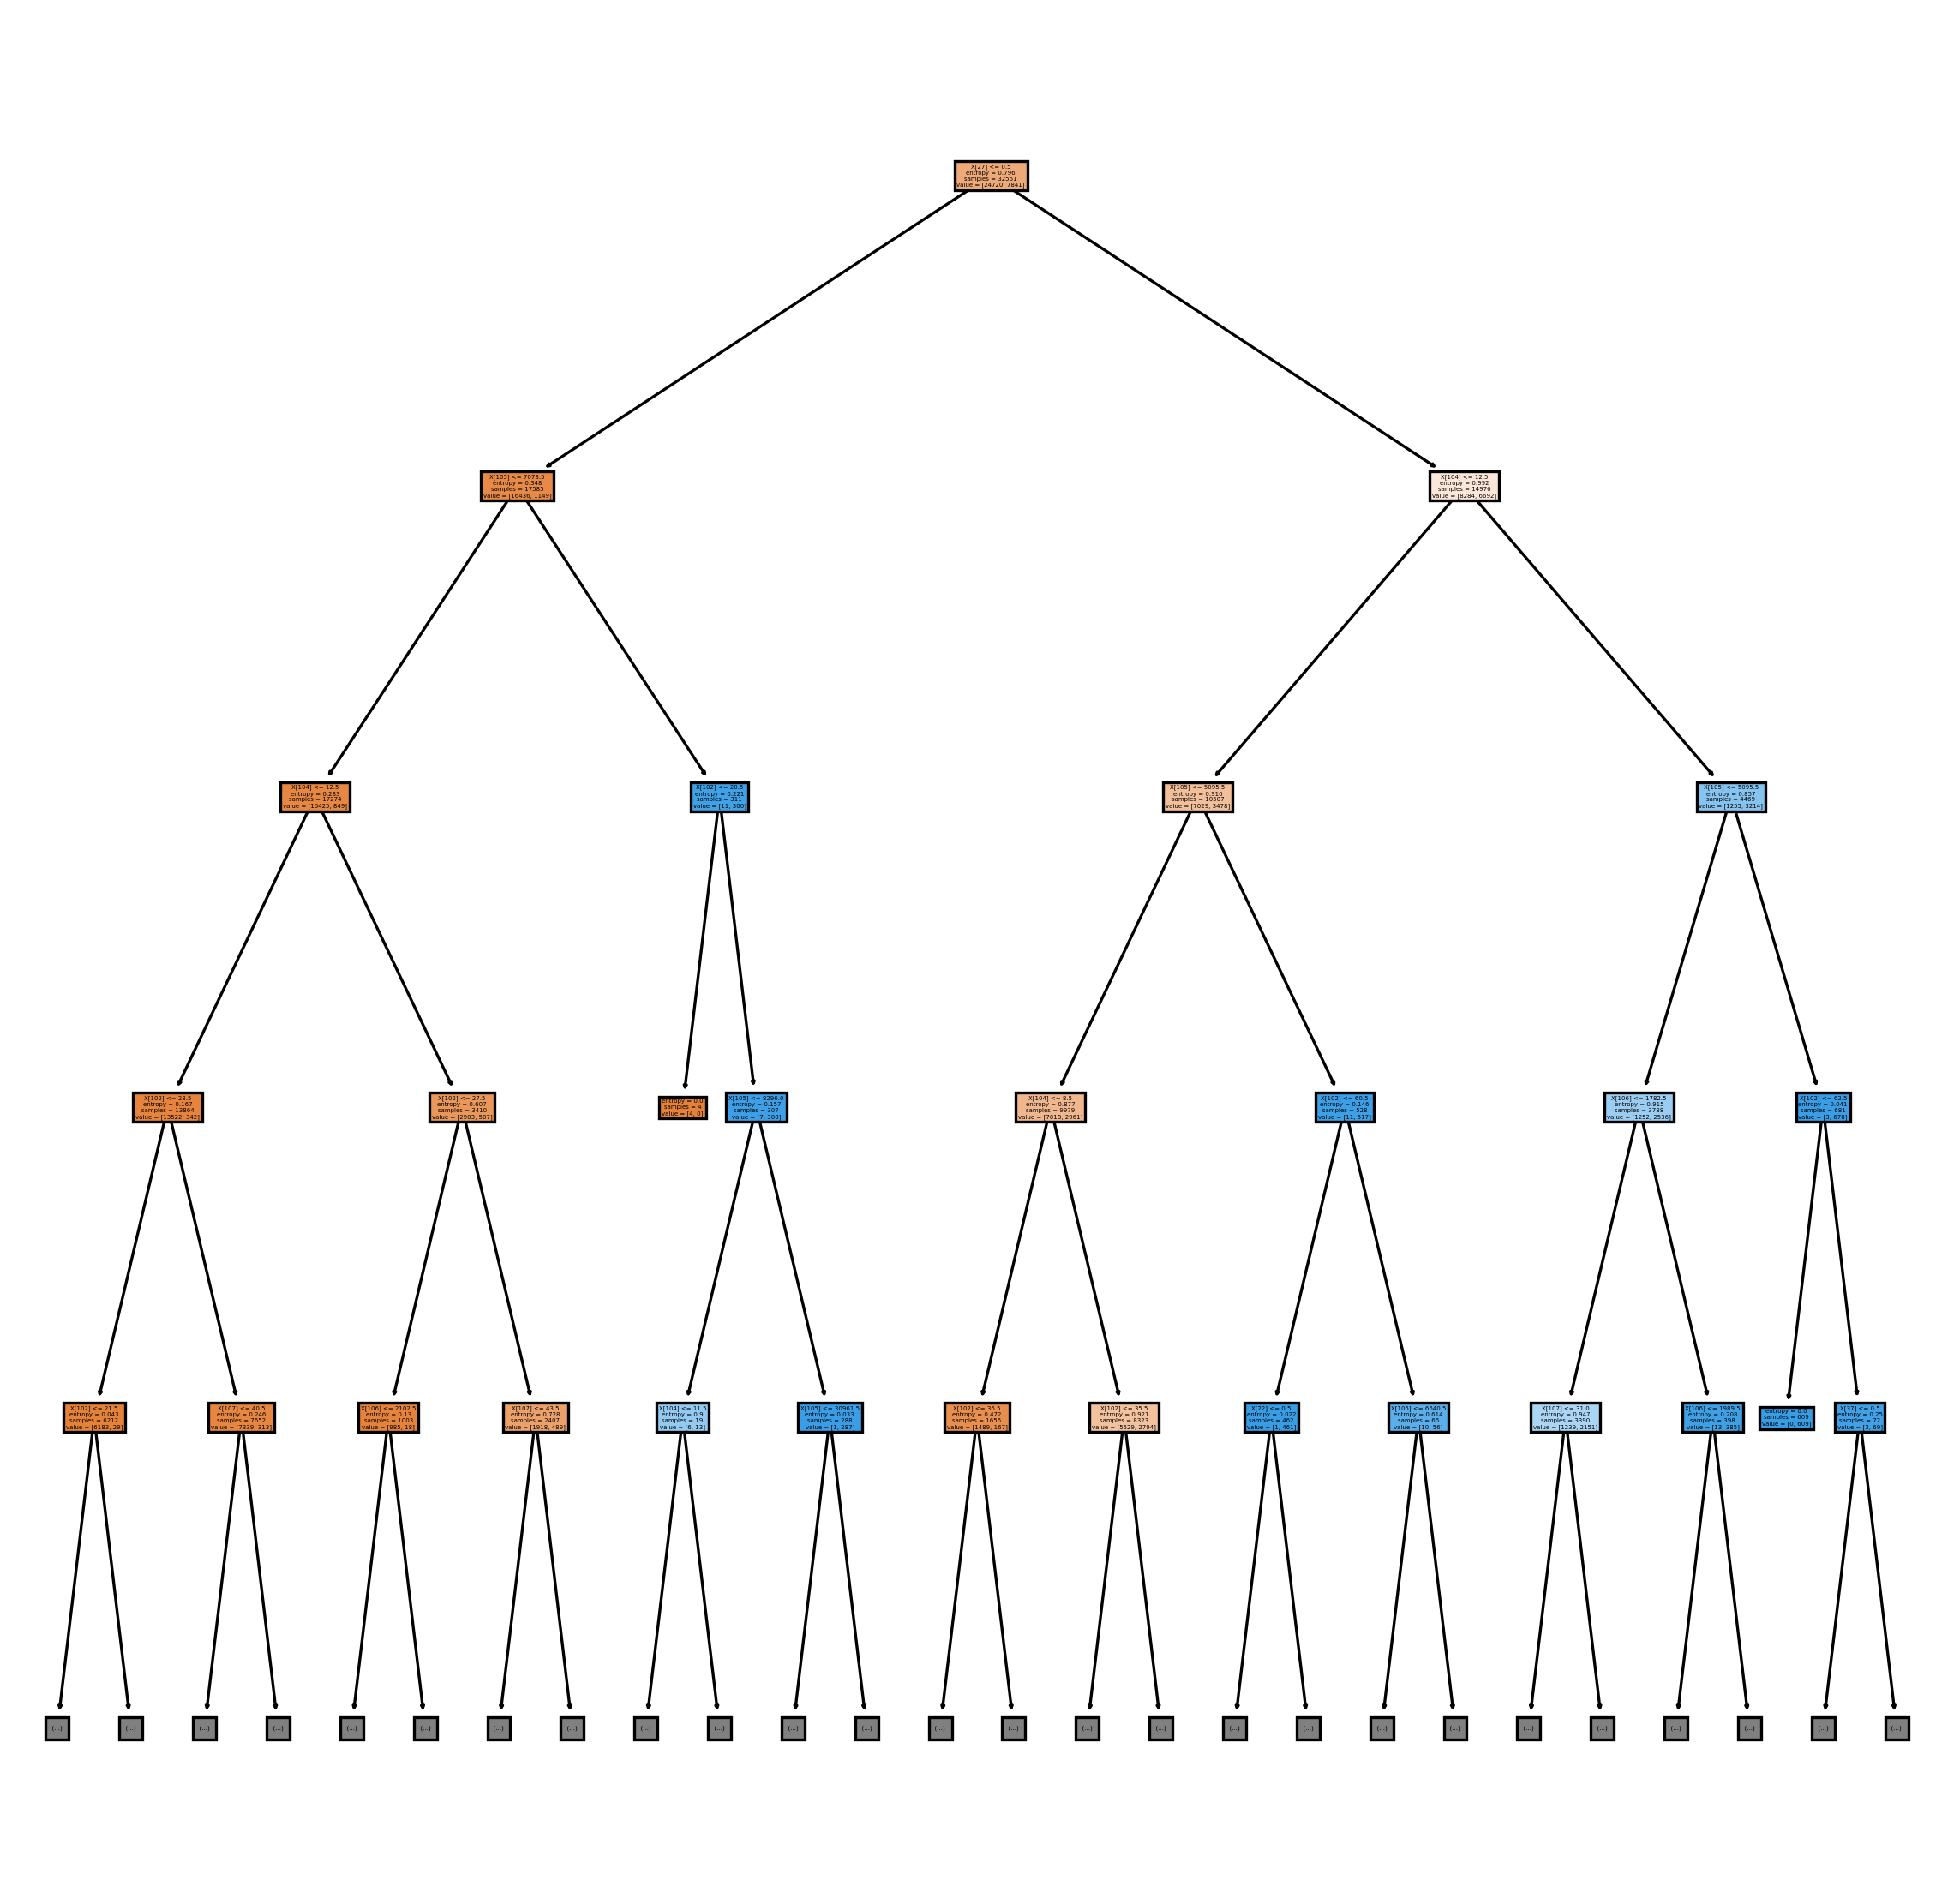

In [19]:
plt.figure(figsize=(12,12), dpi=240)
tree.plot_tree(DT_Model,filled = True,max_depth=4)

## XGBoost

In [20]:
XGB_Model = xgb.XGBClassifier()
XGB_Model.fit(x_train,y_train)
XGB_pred = XGB_Model.predict(x_test)
XGB_score = accuracy_score(XGB_pred,y_test)
print(XGB_score)


0.8666188965093664


## Neural Network

In [77]:
NN_model = ks.models.Sequential()

NN_model.add(ks.layers.Dense(100, activation='relu', input_dim=108))
NN_model.add(ks.layers.Dense(1,activation='sigmoid'))

In [78]:
NN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

NN_model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['binary_accuracy'])

NN_model.fit(x_train,y_train,epochs=30,batch_size=100,validation_data=(x_test, y_test))
loss, accuracy = NN_model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, NN_score = NN_model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(NN_score))

Epoch 1/30
228/228 [==============================] - 1s 3ms/step - loss: 646.4728 - binary_accuracy: 0.6898 - val_loss: 167.1405 - val_binary_accuracy: 0.2394
Epoch 2/30
228/228 [==============================] - 1s 3ms/step - loss: 156.7450 - binary_accuracy: 0.6800 - val_loss: 190.3869 - val_binary_accuracy: 0.7898
Epoch 3/30
228/228 [==============================] - 1s 3ms/step - loss: 115.9719 - binary_accuracy: 0.6786 - val_loss: 96.3605 - val_binary_accuracy: 0.7975
Epoch 4/30
228/228 [==============================] - 1s 3ms/step - loss: 111.8205 - binary_accuracy: 0.6859 - val_loss: 20.6448 - val_binary_accuracy: 0.7827
Epoch 5/30
228/228 [==============================] - 1s 3ms/step - loss: 94.9090 - binary_accuracy: 0.6831 - val_loss: 28.1411 - val_binary_accuracy: 0.2412
Epoch 6/30
228/228 [==============================] - 1s 3ms/step - loss: 132.0614 - binary_accuracy: 0.6797 - val_loss: 114.5560 - val_binary_accuracy: 0.2394
Epoch 7/30
228/228 [========================

In [56]:
NN_model.summary()
clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10900     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,001
Trainable params: 11,001
Non-trainable params: 0
_________________________________________________________________


## Q1 Results

In [95]:
Q1Res = pd.DataFrame()
Q1Res = Q1Res.append({"LogRes":LogResScore,"SVM":SVM_Score,"KNN":max(KNN_scores),"DT":DT_Score,"XGB":XGB_score,"NN":NN_score},ignore_index = True)
Q1Res.head()

,LogRes,SVM,KNN,DT,XGB,NN
0,0.854642,0.79957,0.796704,0.990019,0.866619,0.798956


# Q2

For this question we are going to use [the Dry Bean Dataset](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset):

Construct 

- Logistic regression
- SVM
- KNN
- Decision tree
- Gradient Boost (XGBoost)
- Neural network

models for the data. Cross-validate your models and measure the accuracies. Compare them putting the accuracies in a table.

In [21]:
#with urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip') as url:
#    zf = ZipFile(BytesIO(url.read()))
#    data = pd.read_excel(zf.open('DryBeanDataset/Dry_Bean_Dataset.xlsx'))
    
#data

# Q3

For this question we are going to use the [Japanese MNIST](https://github.com/rois-codh/kmnist) dataset.

Construct a convolutional neural network model for the dataset and cross-validate your model.

# Q4

For this question we are going to use Box and Jenkins Airline Passenger Dataset. For this dataset, please install the `rdatasets` library:

In [22]:
#!pip install rdatasets
#from rdatasets import data

In [23]:
#airline = data('AirPassengers')

#plt.figure(figsize=(12,4))
#airline['value'].plot()

In [24]:
#train = airline['value'][:123]
#test = airline['value'][123:]

Construct

- recurrent 
- LSTM

neutral network models on the train set (the first 122 values), and then test it on the last 24 values.